# Summer School on Data Science Tools and Techniques in Modelling Complex Networks

### [Bogumił Kamiński](http://bogumilkaminski.pl/about/)

## Working with graph data using Julia Language
### Day 2, Tuesday, August 20th, 2019, 13:00 to 16:00

## Spatial Preferrential Attachment

In [1]:
using Pkg
Pkg.activate(".")

using LightGraphs, GraphPlot, Roots, Random, PyPlot

structure holding SPA Graph data

In [2]:
mutable struct SPAGraph{T<:DiGraph}
    g::T
    p::Float64
    A₁::Float64
    A₂::Float64
    l::Vector{Tuple{Float64,Float64}}
end

squared distance between $(x_1, y_1)$ and $(x_2, y_2)$ on $[0,1]^2$ torus

In [3]:
function d²torus(d)
    if d > 0.5
        d = 1.0 - d
    elseif d < -0.5
        d = 1.0 + d
    end
    return d^2
end

euclidean(x₁, y₁, x₂, y₂) = sqrt(d²torus(x₁-x₂) + d²torus(y₁-y₂))

euclidean (generic function with 1 method)

calculates ball radius on $[0,1]^2$ torus

In [4]:
function vol2r(vol)
    vol ≤ π/4 && return sqrt(vol/π)
    vol ≥ 1.0 && return sqrt(0.5)
    x = find_zero((0.5, sqrt(0.5))) do r
        π*r^2 - 4 * (r^2*acos(0.5/r) - 0.5*sqrt(r^2-0.25)) - vol
    end
    return x
end

vol2r (generic function with 1 method)

randomly decide if an edge from $j$ to $i$ should be added

In [5]:
function sample_edge(sg::SPAGraph, i, j)
    vol = (sg.A₁*indegree(sg.g, j)+sg.A₂)/(i-1)
    r = vol2r(vol)
    if euclidean(sg.l[i]..., sg.l[j]...) ≤ r && rand() ≤ sg.p
        add_edge!(sg.g, i, j)
        return true
    end
    return false
end

sample_edge (generic function with 1 method)

a naive SPA graph generator with $O(N^2)$ complexity

In [6]:
function gen_spa(N, p, A₁, A₂)
    g = DiGraph(N)
    l = [(rand(), rand()) for i in 1:N]
    sg = SPAGraph(g, p, A₁, A₂, l)
    for i in 2:N, j in 1:(i-1)
        sample_edge(sg, i, j)
    end
    sg
end

gen_spa (generic function with 1 method)

a more efficient method for growing SPA Graph

In [7]:
function split_g(g, l, A₁, A₂, p)
    n = nv(g)
    T = n^(1-1/(p*A₁+1)) * (9*p*A₁*A₂/π)^(1/(p*A₁+1))
    k = π*n / (A₂ * (1 + (n/T)^(p*A₁)))
    d = floor(Int, (π*n / k - A₂) / A₁)
    sqk = floor(Int,sqrt(k))

    heavy = Set{Int}()
    light = [Set{Int}() for i in 1:sqk, j in 1:sqk]

    for i in vertices(g)
        if indegree(g, i) ≥ d
            push!(heavy, i)
        else
            x, y = l[i]
            push!(light[1 + floor(Int, x * sqk), 1 + floor(Int, y * sqk)], i)
        end
    end
    sqk, d, heavy, light
end

function grow_spa!(ΔN, sg::SPAGraph)
    sqk, d, heavy, light = split_g(sg.g, sg.l, sg.A₁, sg.A₂, sg.p)
    N = nv(sg.g)
    add_vertices!(sg.g, ΔN)
    append!(sg.l, [(rand(), rand()) for i in 1:ΔN])
    for i in (N+1):(N+ΔN)
        for j in heavy
            sample_edge(sg, i, j)
        end
        x, y = sg.l[i]
        cx, cy = 1 .+ floor.(Int, (x,y) .* sqk)
        for dx in -1:1, dy in -1:1
            ccx = mod1(cx + dx, sqk)
            ccy = mod1(cy + dy, sqk)
            to_heavy = Int[]
            for j in light[ccx, ccy]
                if sample_edge(sg, i, j) && indegree(sg.g, j) ≥ d
                    push!(to_heavy, j)
                end
            end
            for j in to_heavy
                pop!(light[ccx, ccy], j)
                push!(heavy, j)
            end
        end
        push!(light[cx, cy], i)
    end
    sg
end

grow_spa! (generic function with 1 method)

In [8]:
p = 0.1
A₁ = 1.0
d = 10.0

10.0

In [9]:
g1 = gen_spa(20, p, A₁, d*(1/p-A₁))

SPAGraph{SimpleDiGraph{Int64}}({20, 15} directed simple Int64 graph, 0.1, 1.0, 90.0, Tuple{Float64,Float64}[(0.148545, 0.947355), (0.763146, 0.0218452), (0.0304072, 0.416002), (0.888035, 0.870515), (0.432326, 0.482816), (0.109801, 0.782861), (0.800048, 0.592645), (0.510327, 0.196211), (0.261821, 0.329308), (0.973312, 0.72619), (0.722827, 0.296845), (0.250953, 0.324916), (0.16693, 0.820473), (0.940245, 0.240082), (0.978334, 0.964474), (0.783531, 0.601075), (0.757769, 0.579275), (0.599687, 0.304754), (0.383797, 0.761616), (0.909075, 0.148385)])

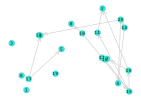

In [10]:
gplot(g1.g, getindex.(g1.l, 1), getindex.(g1.l, 2), nodelabel=1:nv(g1.g))

### Mean degree

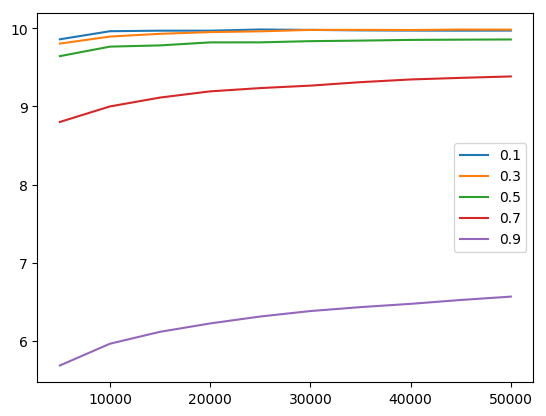

PyObject <matplotlib.legend.Legend object at 0x0000000001155240>

In [11]:
res = Vector{Float64}[]
for (i, p) in enumerate(0.1:0.2:0.9)
    g = gen_spa(5000, p, A₁, d*(1/p-A₁))
    push!(res, [ne(g.g)/nv(g.g)])
    for j in 1:9
        grow_spa!(5000, g)
        push!(res[i], ne(g.g)/nv(g.g))
    end
end
foreach(x -> plot(5000:5000:50000, x), res)
legend(0.1:0.2:0.9)

### Giant component

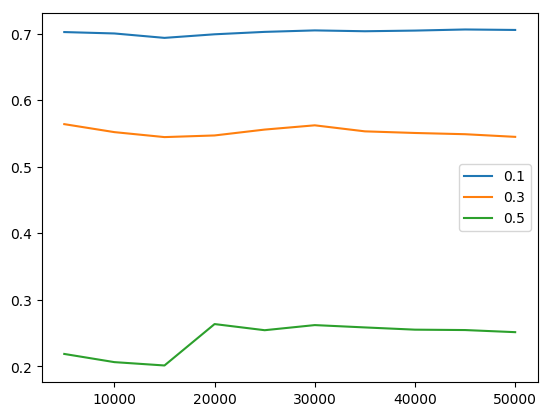

PyObject <matplotlib.legend.Legend object at 0x00000000011BB518>

In [12]:
res = Vector{Float64}[]
d = 1
for (i, p) in enumerate(0.1:0.2:0.5)
    g = gen_spa(5000, p, A₁, d*(1/p-A₁))
    push!(res, [maximum(length.(weakly_connected_components(g.g))) / nv(g.g)])
    for j in 1:9
        grow_spa!(5000, g)
        push!(res[i], maximum(length.(weakly_connected_components(g.g))) / nv(g.g))
    end
end
foreach(x -> plot(5000:5000:50000, x), res)
legend(0.1:0.2:0.5)

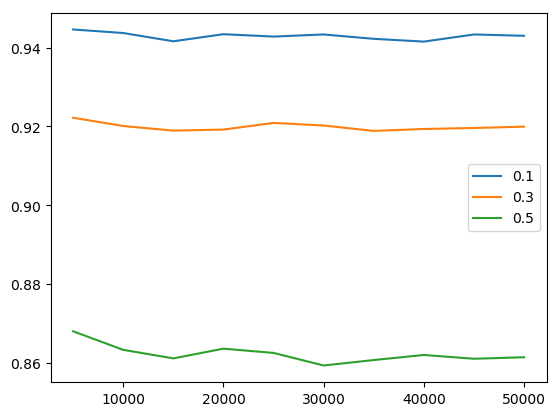

PyObject <matplotlib.legend.Legend object at 0x0000000001229BA8>

In [13]:
res = Vector{Float64}[]
d = 2
for (i, p) in enumerate(0.1:0.2:0.5)
    g = gen_spa(5000, p, A₁, d*(1/p-A₁))
    push!(res, [maximum(length.(weakly_connected_components(g.g))) / nv(g.g)])
    for j in 1:9
        grow_spa!(5000, g)
        push!(res[i], maximum(length.(weakly_connected_components(g.g))) / nv(g.g))
    end
end
foreach(x -> plot(5000:5000:50000, x), res)
legend(0.1:0.2:0.5)